# Transfer Function Interrupted Time Series: Single Channel Example

This notebook demonstrates how to use the Transfer Function ITS (TF-ITS) method to estimate the causal effect of a graded intervention (e.g., media spend, policy intensity) in a single market. This approach builds on the foundational work of {cite:p}`box1975intervention` on intervention analysis with transfer functions, extending it to incorporate modern saturation and adstock transformations commonly used in marketing mix modeling.

**Key Features:**
- Saturation transforms (Hill, logistic) for diminishing returns
- Adstock (carryover) transforms for lagged effects
- Counterfactual effect estimation
- Diagnostic tests for model validity

**MVP Note:** This implementation uses OLS with HAC standard errors for fast point estimates. Future extensions will add bootstrap confidence intervals and Bayesian inference.

**When to use TF-ITS vs other methods:**
- **TF-ITS**: Single market, graded intervention with saturation/carryover (e.g., media spend, policy intensity)
- **Classic ITS**: Single market, on/off intervention (e.g., policy change)
- **Synthetic Control**: Multi-market with control units available


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

# Set random seed for reproducibility
np.random.seed(42)

%config InlineBackend.figure_format = 'retina'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


## 1. Generate Simulated Data

We'll simulate weekly sales data with:
- A baseline trend and seasonality
- TV advertising spend with saturation and adstock effects
- A "flight" period (weeks 50-65) where TV spend increases significantly


In [2]:
# Generate 104 weeks (2 years) of data
n_weeks = 104
dates = pd.date_range("2022-01-01", periods=n_weeks, freq="W-MON")
t = np.arange(n_weeks)

# Baseline: intercept + trend + seasonality
baseline = 1000 + 2.0 * t + 50 * np.sin(2 * np.pi * t / 52)

# TV spend: low baseline with a flight in weeks 50-65
tv_spend = np.random.uniform(1000, 3000, n_weeks)
tv_spend[50:66] = np.random.uniform(8000, 12000, 16)  # Flight period

# Apply "true" transforms to generate the data using pure numpy
# (Note: for data generation, we use numpy. For model fitting, we use CausalPy's transforms)

# Saturation: Hill function with k=5000, s=2.0
kappa = 5000
slope = 2.0
tv_saturated = tv_spend**slope / (kappa**slope + tv_spend**slope)

# Adstock: geometric with half-life of 3 weeks
# Implement geometric adstock manually for data generation
half_life = 3.0
alpha = np.power(0.5, 1 / half_life)  # decay rate
l_max = 12

# Apply geometric adstock convolution
tv_transformed = np.zeros_like(tv_saturated)
adstock_weights = np.power(alpha, np.arange(l_max + 1))
adstock_weights = adstock_weights / adstock_weights.sum()  # normalize

for t_idx in range(n_weeks):
    for lag in range(min(l_max + 1, t_idx + 1)):
        tv_transformed[t_idx] += adstock_weights[lag] * tv_saturated[t_idx - lag]

# Generate sales: baseline + treatment effect + noise
theta_true = 500  # Treatment coefficient
sales = baseline + theta_true * tv_transformed + np.random.normal(0, 30, n_weeks)

# Create DataFrame
df = pd.DataFrame({"date": dates, "t": t, "sales": sales, "tv_spend": tv_spend})
df = df.set_index("date")

print(df.head())
print(f"\nData shape: {df.shape}")
print(f"Sales range: [{df['sales'].min():.0f}, {df['sales'].max():.0f}]")
print(f"TV spend range: [{df['tv_spend'].min():.0f}, {df['tv_spend'].max():.0f}]")

            t        sales     tv_spend
date                                   
2022-01-03  0   990.771751  1749.080238
2022-01-10  1  1034.929456  2901.428613
2022-01-17  2  1054.564324  2463.987884
2022-01-24  3  1037.364996  2197.316968
2022-01-31  4  1092.781383  1312.037281

Data shape: (104, 3)
Sales range: [991, 1639]
TV spend range: [1011, 11719]


## 2. Visualize the Data

Let's look at the sales and TV spend time series, highlighting the flight period.


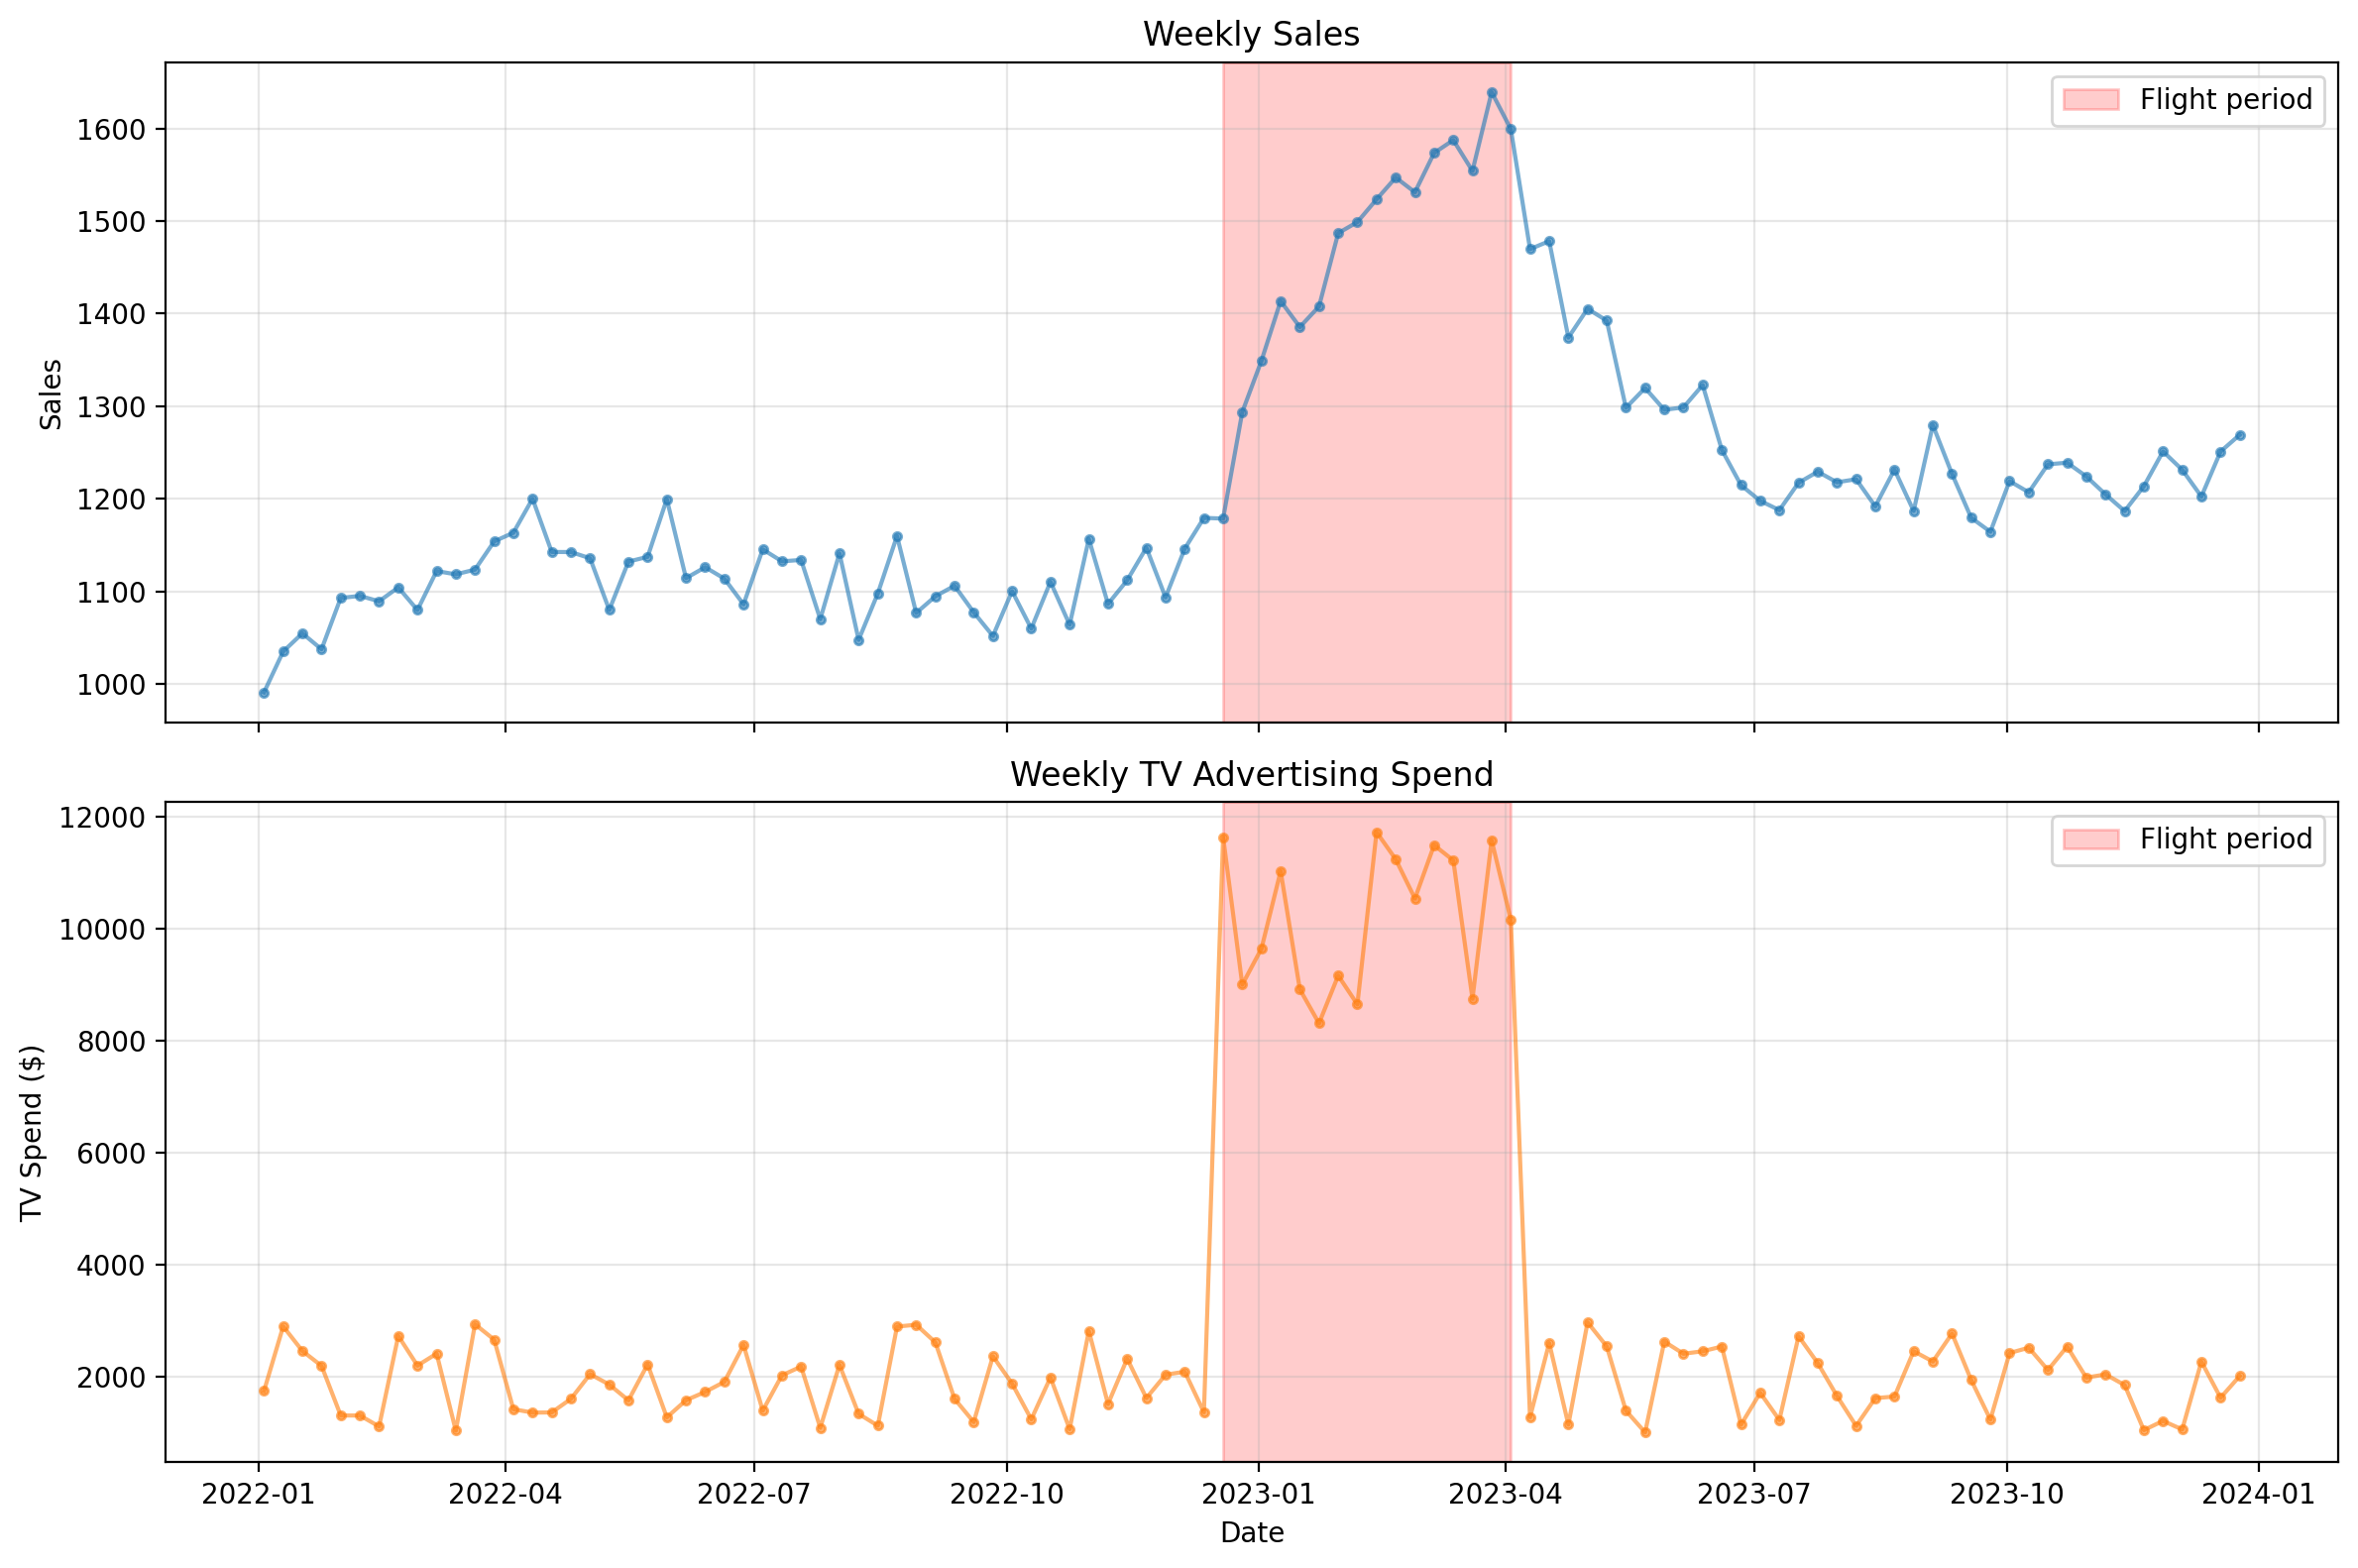

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Sales
axes[0].plot(df.index, df["sales"], "o-", alpha=0.6, markersize=3)
axes[0].axvspan(
    df.index[50], df.index[65], alpha=0.2, color="red", label="Flight period"
)
axes[0].set_ylabel("Sales")
axes[0].set_title("Weekly Sales")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TV spend
axes[1].plot(df.index, df["tv_spend"], "o-", alpha=0.6, markersize=3, color="C1")
axes[1].axvspan(
    df.index[50], df.index[65], alpha=0.2, color="red", label="Flight period"
)
axes[1].set_ylabel("TV Spend ($)")
axes[1].set_title("Weekly TV Advertising Spend")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Fit the Transfer Function ITS Model

We'll specify:
- A baseline formula with trend and seasonality
- A treatment channel (TV spend) with Hill saturation and geometric adstock transforms

**Note:** In practice, you would tune the transform parameters based on domain knowledge or grid search (future feature).


In [4]:
# Define the treatment with transforms
tv_treatment = cp.Treatment(
    name="tv_spend",
    transforms=[
        cp.Saturation(kind="hill", slope=2.0, kappa=5000),  # Half-saturation at $5000
        cp.Adstock(half_life=3.0, normalize=True, l_max=12),  # 3-week half-life
    ],
    coef_constraint="nonnegative",
)

# Fit the model
result = cp.TransferFunctionITS(
    data=df,
    y_column="sales",
    base_formula="1 + t + np.sin(2*np.pi*t/52) + np.cos(2*np.pi*t/52)",
    treatments=[tv_treatment],
    hac_maxlags=8,
)

print("Model fitted successfully!")
print(f"R-squared: {result.score:.4f}")

Model fitted successfully!
R-squared: 0.9650


## 4. Model Summary

Let's examine the fitted coefficients.


In [5]:
# Print model summary
result.summary(round_to=2)

Transfer Function Interrupted Time Series Results
Outcome variable: sales
Number of observations: 104
R-squared: 0.96
HAC max lags: 8
--------------------------------------------------------------------------------
Baseline coefficients:
  Intercept           :        994 (SE: 2.8)
  t                   :        2.1 (SE: 0.065)
  np.sin(2 * np.pi * t / 52):         53 (SE: 3.1)
  np.cos(2 * np.pi * t / 52):       -8.7 (SE: 2.4)
--------------------------------------------------------------------------------
Treatment coefficients:
  tv_spend            :        499 (SE: 8.1)


In [6]:
# Check if we recovered the true treatment coefficient
print(f"\nTrue treatment coefficient: {theta_true}")
print(f"Estimated treatment coefficient: {result.theta_treatment[0]:.2f}")


True treatment coefficient: 500
Estimated treatment coefficient: 499.36


## 5. Plot Model Fit and Diagnostics


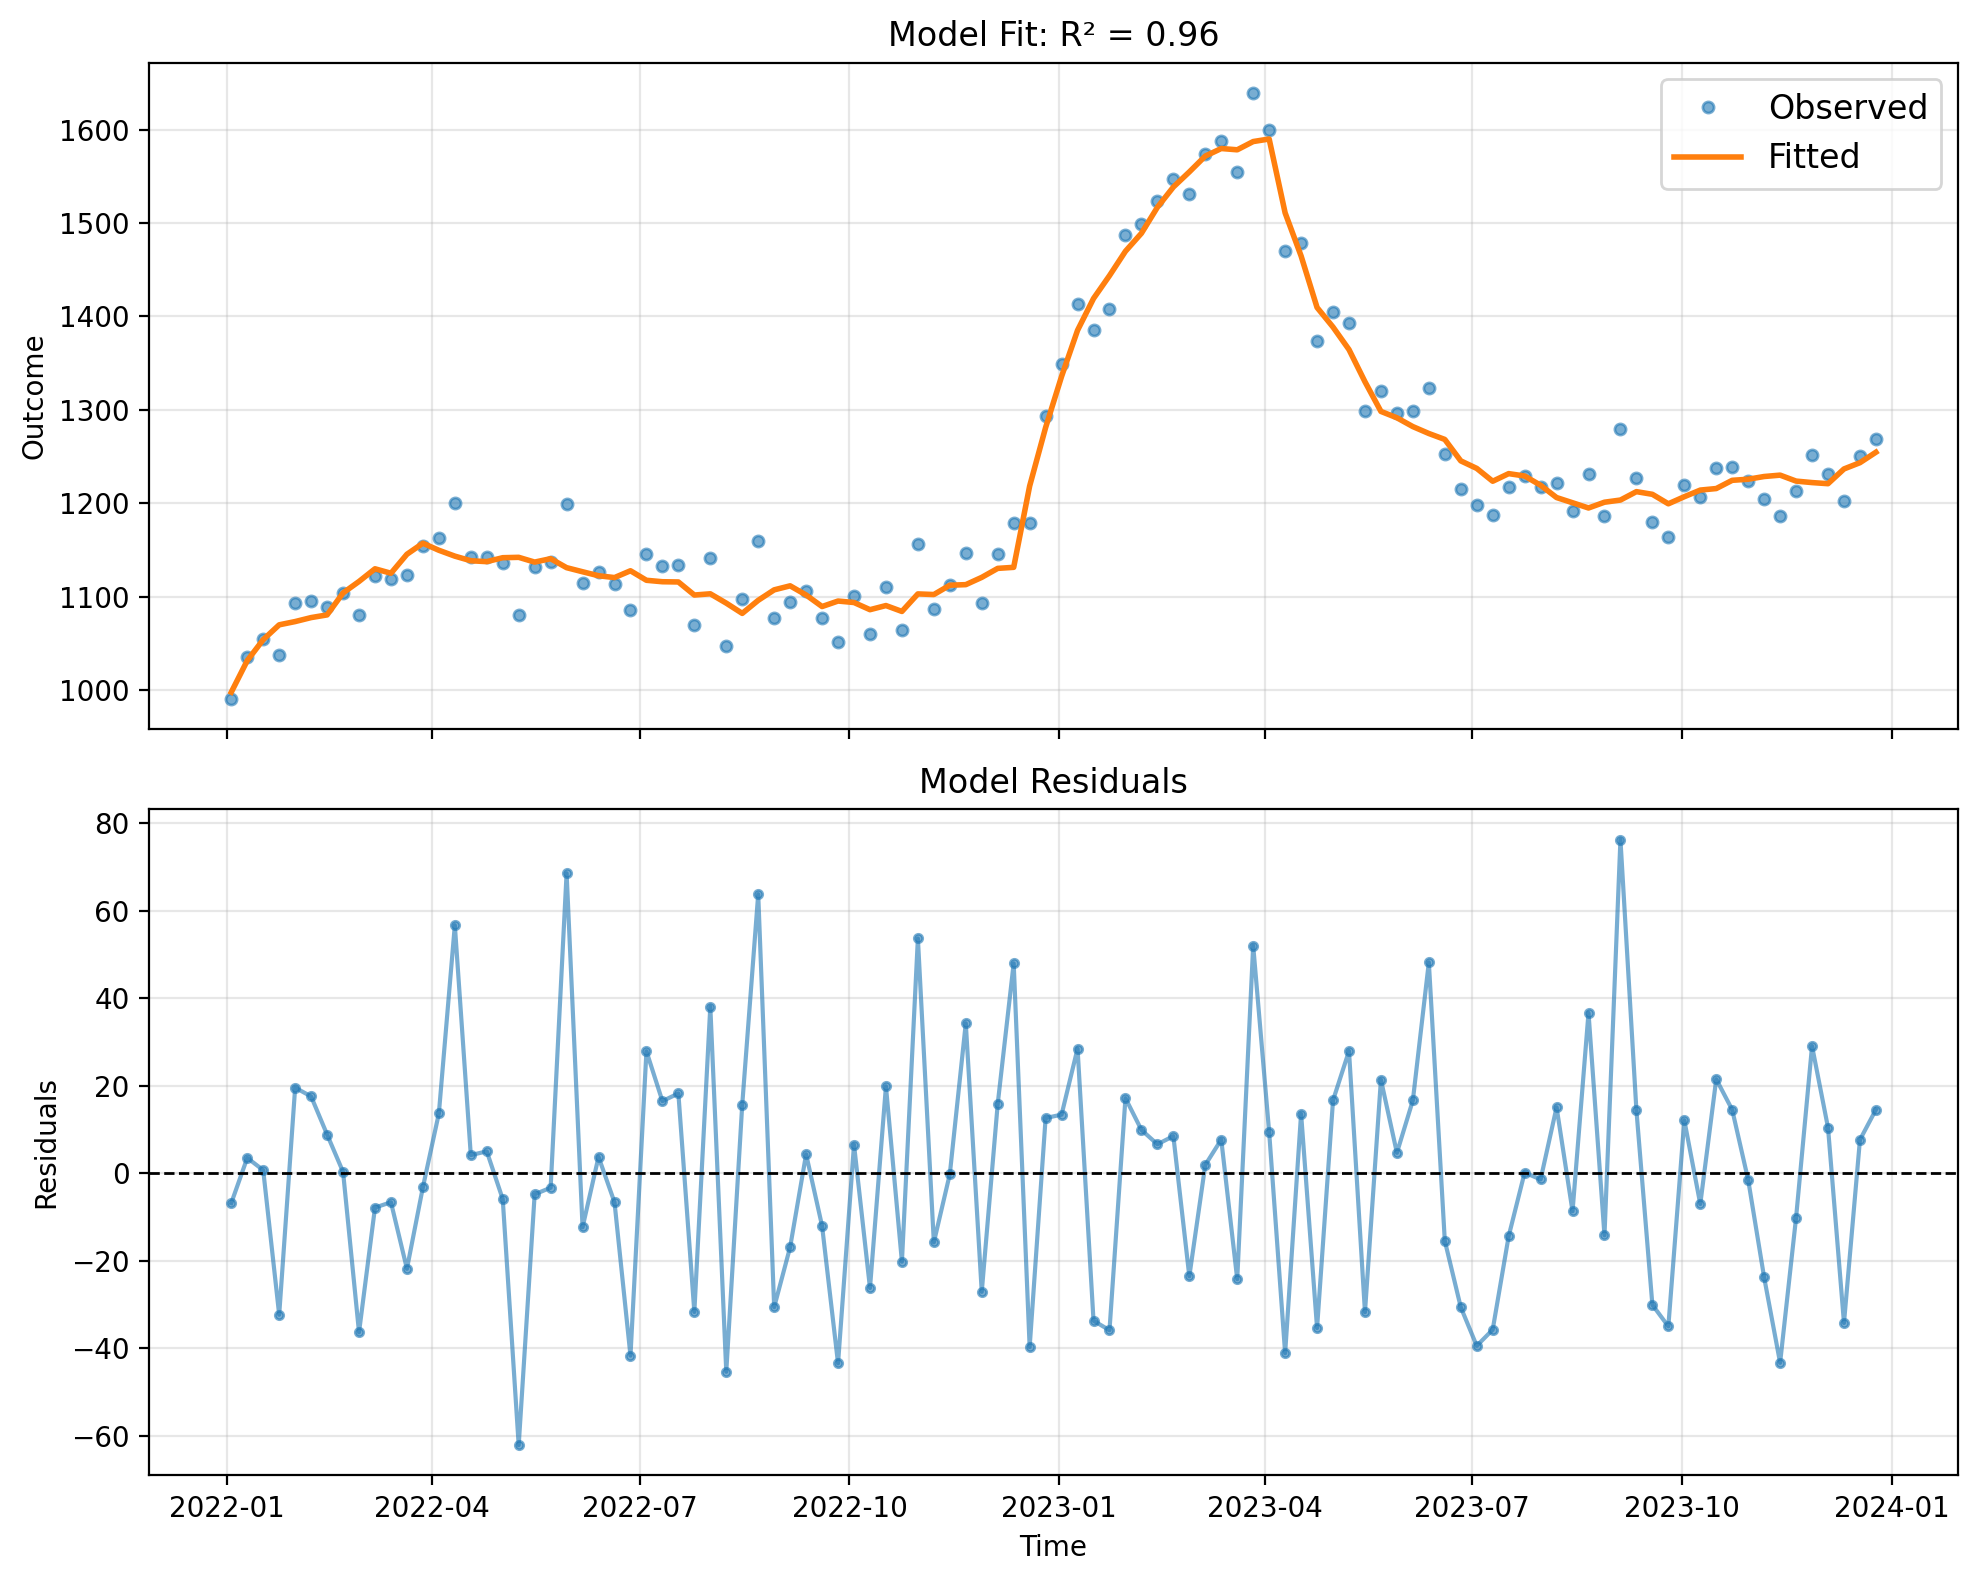

In [7]:
# Plot observed vs fitted
fig, ax = result.plot()

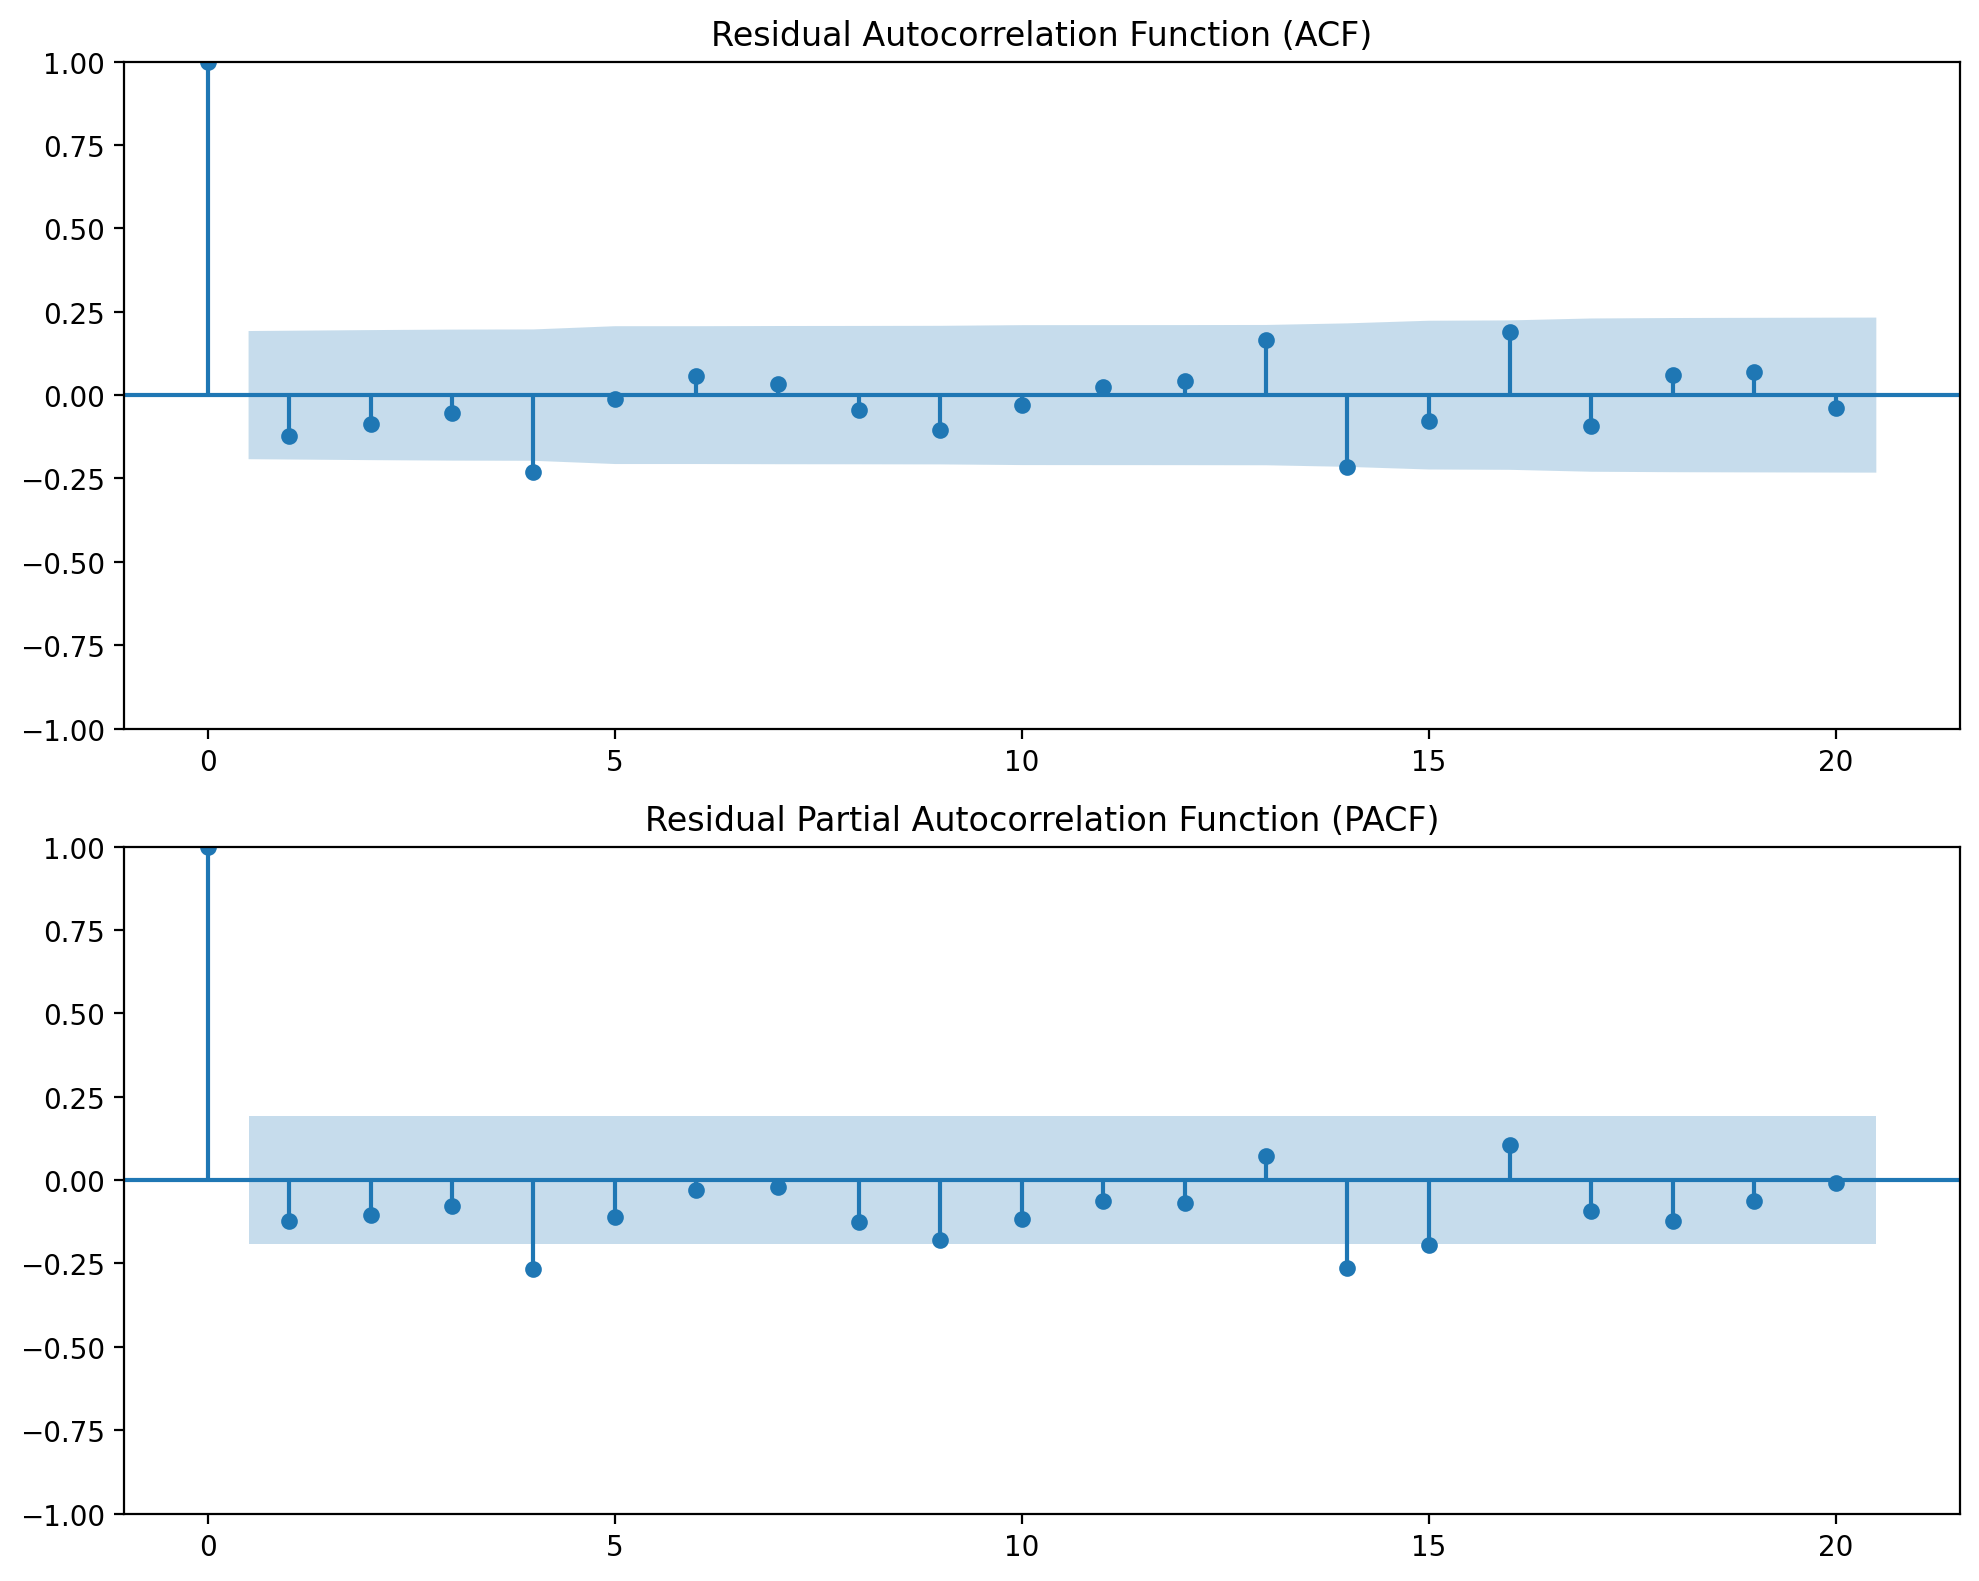


Ljung-Box Test for Residual Autocorrelation
H0: Residuals are independently distributed (no autocorrelation)
If p-value < 0.05, reject H0 (autocorrelation present)
------------------------------------------------------------
Lag  1: LB statistic =    1.592, p-value = 0.2070 
Lag  5: LB statistic =    8.563, p-value = 0.1278 
Lag 10: LB statistic =   10.695, p-value = 0.3817 
Lag 20: LB statistic =   27.626, p-value = 0.1186 
------------------------------------------------------------
✓ No significant residual autocorrelation detected.


In [8]:
# Run diagnostics
result.diagnostics(lags=20)

## 6. Impulse Response Function

Visualize how a one-unit increase in (saturated) TV spend propagates over time.


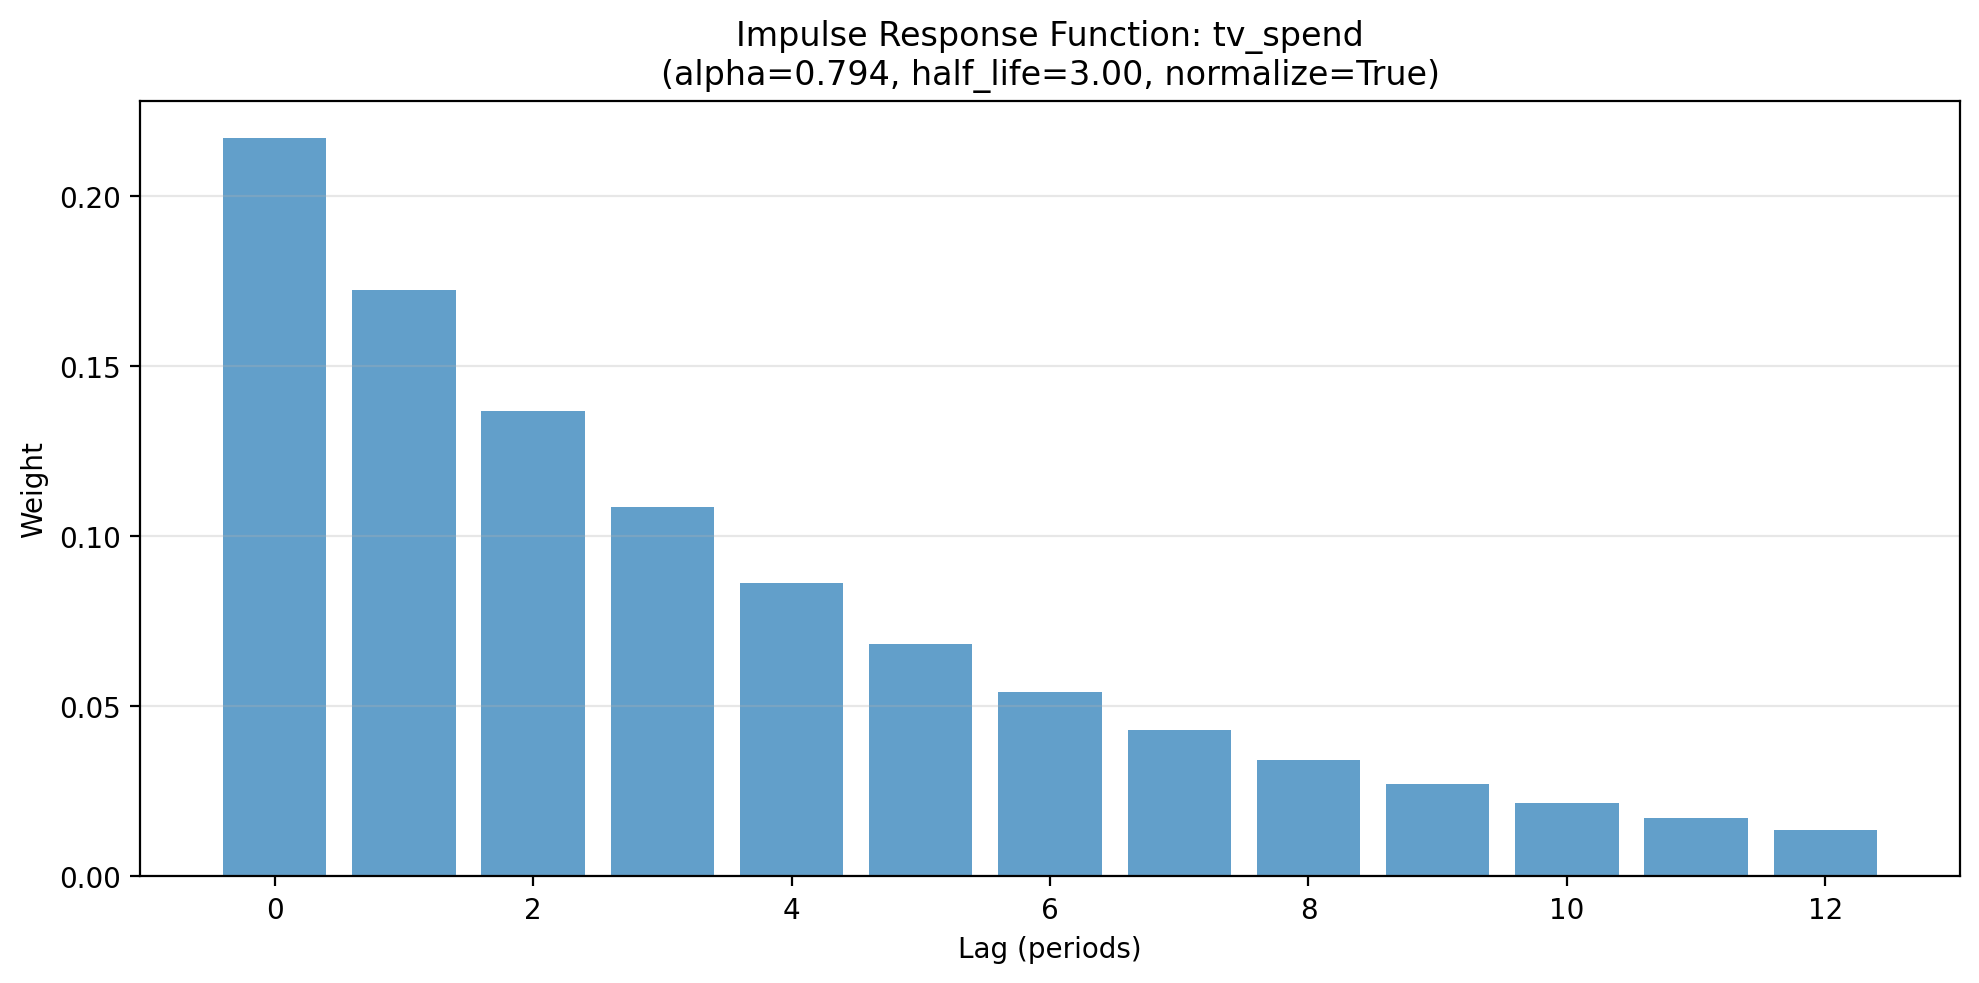

In [9]:
# Plot IRF for TV channel
fig = result.plot_irf("tv_spend", max_lag=12)

## 7. Estimate Causal Effects

Estimate the causal effect of the TV flight by computing what sales would have been if TV spend had remained at baseline levels.


In [10]:
# Estimate effect of zeroing TV spend during flight
flight_start = df.index[50]
flight_end = df.index[65]

effect_result = result.effect(
    window=(flight_start, flight_end),
    channels=["tv_spend"],
    scale=0.0,  # Zero out TV spend
)

print("Effect of removing TV spend during flight:")
print(f"Total effect: {effect_result['total_effect']:.2f}")
print(f"Mean weekly effect: {effect_result['mean_effect']:.2f}")

Effect of removing TV spend during flight:
Total effect: 5171.95
Mean weekly effect: 323.25


## 8. Visualize Counterfactual Analysis


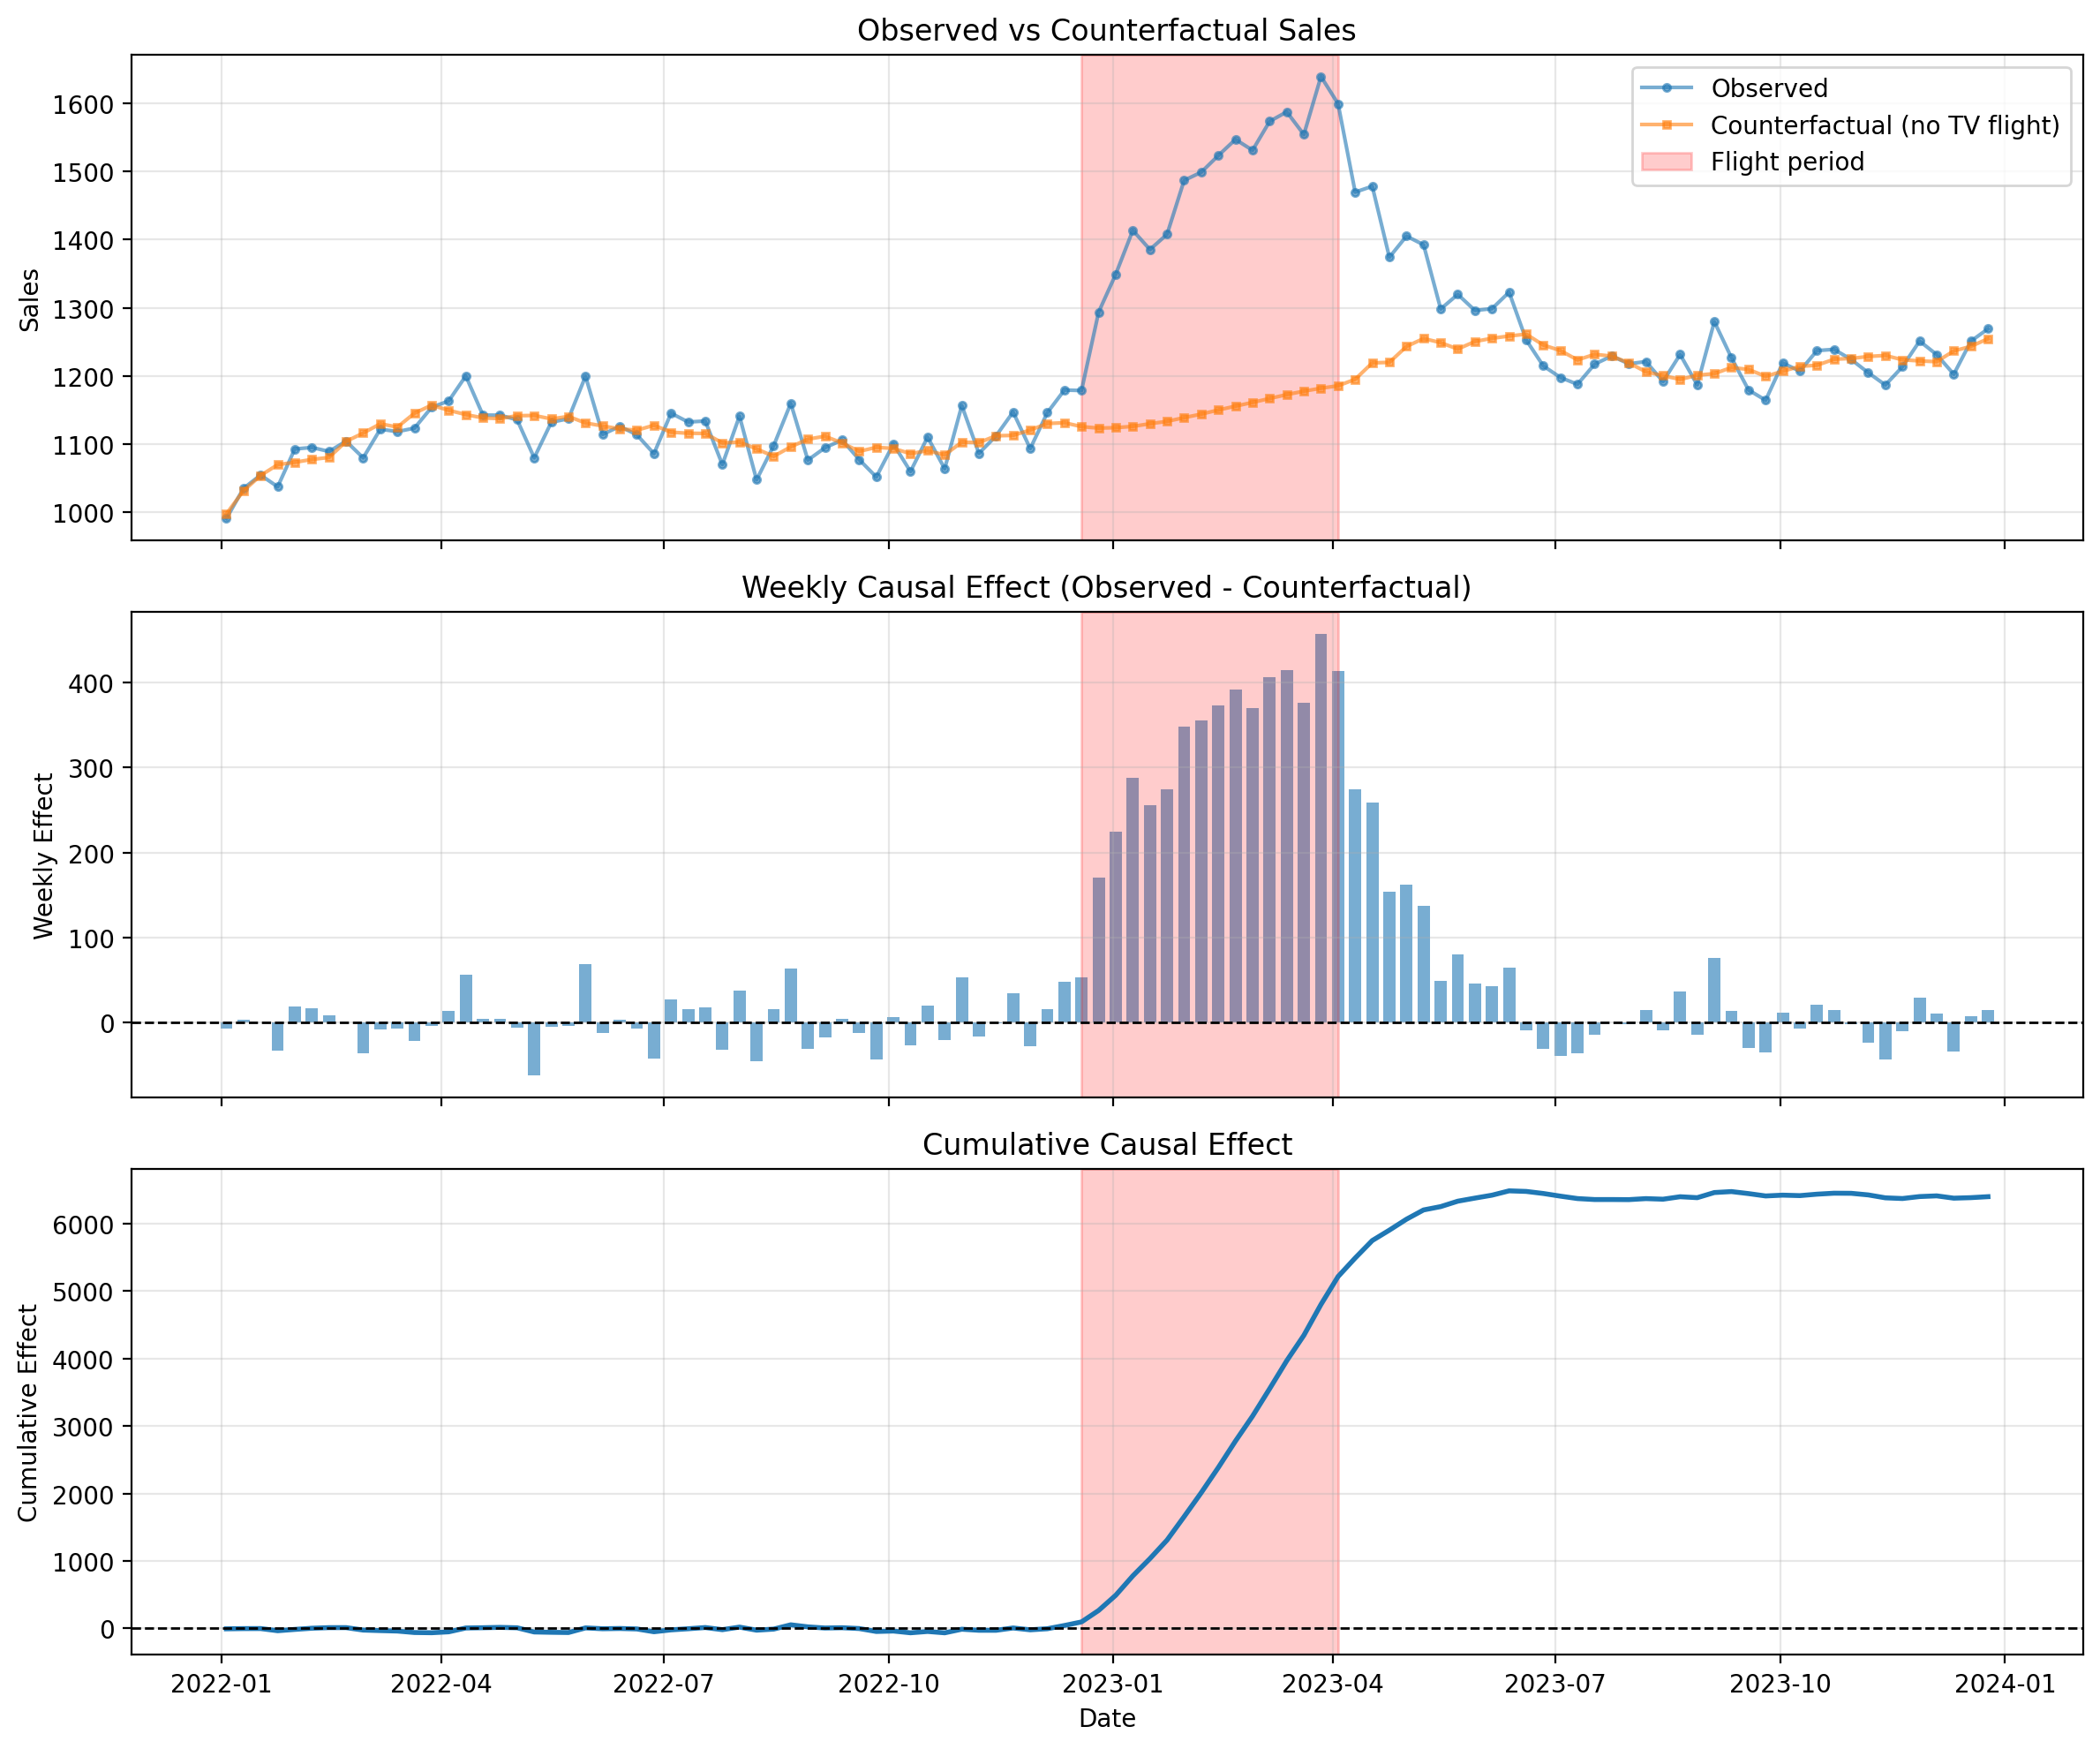

In [11]:
# Plot observed vs counterfactual
effect_df = effect_result["effect_df"]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Panel 1: Observed vs Counterfactual
axes[0].plot(
    effect_df.index,
    effect_df["observed"],
    "o-",
    alpha=0.6,
    markersize=3,
    label="Observed",
)
axes[0].plot(
    effect_df.index,
    effect_df["counterfactual"],
    "s-",
    alpha=0.6,
    markersize=3,
    label="Counterfactual (no TV flight)",
    color="C1",
)
axes[0].axvspan(flight_start, flight_end, alpha=0.2, color="red", label="Flight period")
axes[0].set_ylabel("Sales")
axes[0].set_title("Observed vs Counterfactual Sales")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Weekly Effect
axes[1].bar(effect_df.index, effect_df["effect"], alpha=0.6, width=5)
axes[1].axhline(y=0, color="k", linestyle="--", linewidth=1)
axes[1].axvspan(flight_start, flight_end, alpha=0.2, color="red")
axes[1].set_ylabel("Weekly Effect")
axes[1].set_title("Weekly Causal Effect (Observed - Counterfactual)")
axes[1].grid(True, alpha=0.3)

# Panel 3: Cumulative Effect
axes[2].plot(effect_df.index, effect_df["effect_cumulative"], "-", linewidth=2)
axes[2].axhline(y=0, color="k", linestyle="--", linewidth=1)
axes[2].axvspan(flight_start, flight_end, alpha=0.2, color="red")
axes[2].set_ylabel("Cumulative Effect")
axes[2].set_title("Cumulative Causal Effect")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We have successfully demonstrated Transfer Function ITS analysis, combining classical intervention analysis {cite:p}`box1975intervention` with modern saturation and adstock transforms:

1. Simulated data with known saturation and adstock effects
2. Fitted a Transfer Function ITS model with OLS + HAC standard errors
3. Verified coefficient recovery
4. Visualized diagnostics and impulse response functions
5. Estimated causal effects using counterfactual analysis

**Key insights from this approach:**
- **Transfer functions** model how the effect of an intervention propagates over time through saturation (diminishing returns) and adstock (carryover) mechanisms
- **Counterfactual analysis** allows us to estimate what would have happened without the intervention or with different intervention levels
- **Diagnostic tests** help validate model assumptions about residual independence

**Future extensions:**
- Bootstrap confidence intervals for effect estimates
- Grid search for optimal transform parameters
- Bayesian inference with PyMC for full uncertainty quantification
- Multi-channel analysis with collinearity diagnostics

**References:**
For more on interrupted time series and intervention analysis, see {cite:p}`box1975intervention`. For related quasi-experimental methods in CausalPy, see the {term}`Interrupted Time Series` and {term}`Synthetic Control` documentation.
